In [1]:
import cv2
import numpy as np


In [2]:
#koncowe
def resize_with_padding(image, target_size=(256, 256), is_mask=False):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    if (h, w) == (target_h, target_w):
        return image


    # recznie ustawiamy czy to maska czy nie 
    interp = cv2.INTER_NEAREST if is_mask else cv2.INTER_CUBIC


    if h > target_h or w > target_w:
       
        scale = min(target_w / w, target_h / h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        image = cv2.resize(image, (new_w, new_h), interpolation=interp)
    else:
        new_w, new_h = w, h


    delta_w = target_w - new_w
    delta_h = target_h - new_h

    if delta_w==0 and delta_h==0:
        return image
    
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    new_image = cv2.copyMakeBorder(
        image, 
        top, bottom, left, right, 
        cv2.BORDER_CONSTANT, 
        value=0
    )
    
    return new_image

In [ ]:
class MRIPreprocessingPipeline:
    """
    Pipeline do przetwarzania obrazów MRI (pojedyncze plastry 2D).
    Łączy kroki: resize z paddingem, normalizację, opcjonalnie augmentację.
    Można go używać w Dataset.__getitem__ oraz przy inference.
    """
    
    def __init__(
        self,
        target_size=(256, 256),
        normalize=True,
        norm_per_slice=True,
        clip_percentile=(1, 99),
    ):
        self.target_size = target_size
        self.normalize = normalize
        self.norm_per_slice = norm_per_slice  # normalizacja per plaster vs globalna
        self.clip_percentile = clip_percentile
    
    def _normalize_slice(self, img: np.ndarray) -> np.ndarray:
        """Jedna plaster: clip percentylami + min-max do [0,1]."""
        lo, hi = np.percentile(img, self.clip_percentile)
        img = np.clip(img, lo, hi).astype(np.float32)
        if hi > lo:
            img = (img - lo) / (hi - lo)
        return img
    
    def process_image(self, image: np.ndarray, is_mask: bool = False) -> np.ndarray:
        """
        Przetwarza jeden obraz 2D (plaster MRI lub maska).
        - image: numpy array 2D (H, W)
        - is_mask: True = interpolacja nearest, bez normalizacji
        """
        out = resize_with_padding(image, self.target_size, is_mask=is_mask)
        if not is_mask and self.normalize and self.norm_per_slice:
            out = self._normalize_slice(out)
        return out
    
    def __call__(self, image: np.ndarray, is_mask: bool = False) -> np.ndarray:
        return self.process_image(image, is_mask=is_mask)

In [8]:
import glob

def prepare_brats_samples(base_path):
    samples = []
    # Szukamy folderów pacjentów
    patient_folders = sorted(glob.glob(os.path.join(base_path, 'BraTS20_Training_*')))
    
    for folder in patient_folders:
        p_id = os.path.basename(folder)
        samples.append({
            'flair': os.path.join(folder, f"{p_id}_flair.nii"),
            't1ce':  os.path.join(folder, f"{p_id}_t1ce.nii"),
            't1':    os.path.join(folder, f"{p_id}_t1.nii"),
            't2':    os.path.join(folder, f"{p_id}_t2.nii"),
            'mask':  os.path.join(folder, f"{p_id}_seg.nii"),
            'is_3d': True
        })
    return samples

# Użycie:
brats_samples = prepare_brats_samples('/Users/filip/Desktop/INŻYNIERKA/datasets/BraTS2020 Dataset (Training + Validation)/BraTS2020_TrainingData')
# dataset = MultiModalBrainDataset(brats_samples)

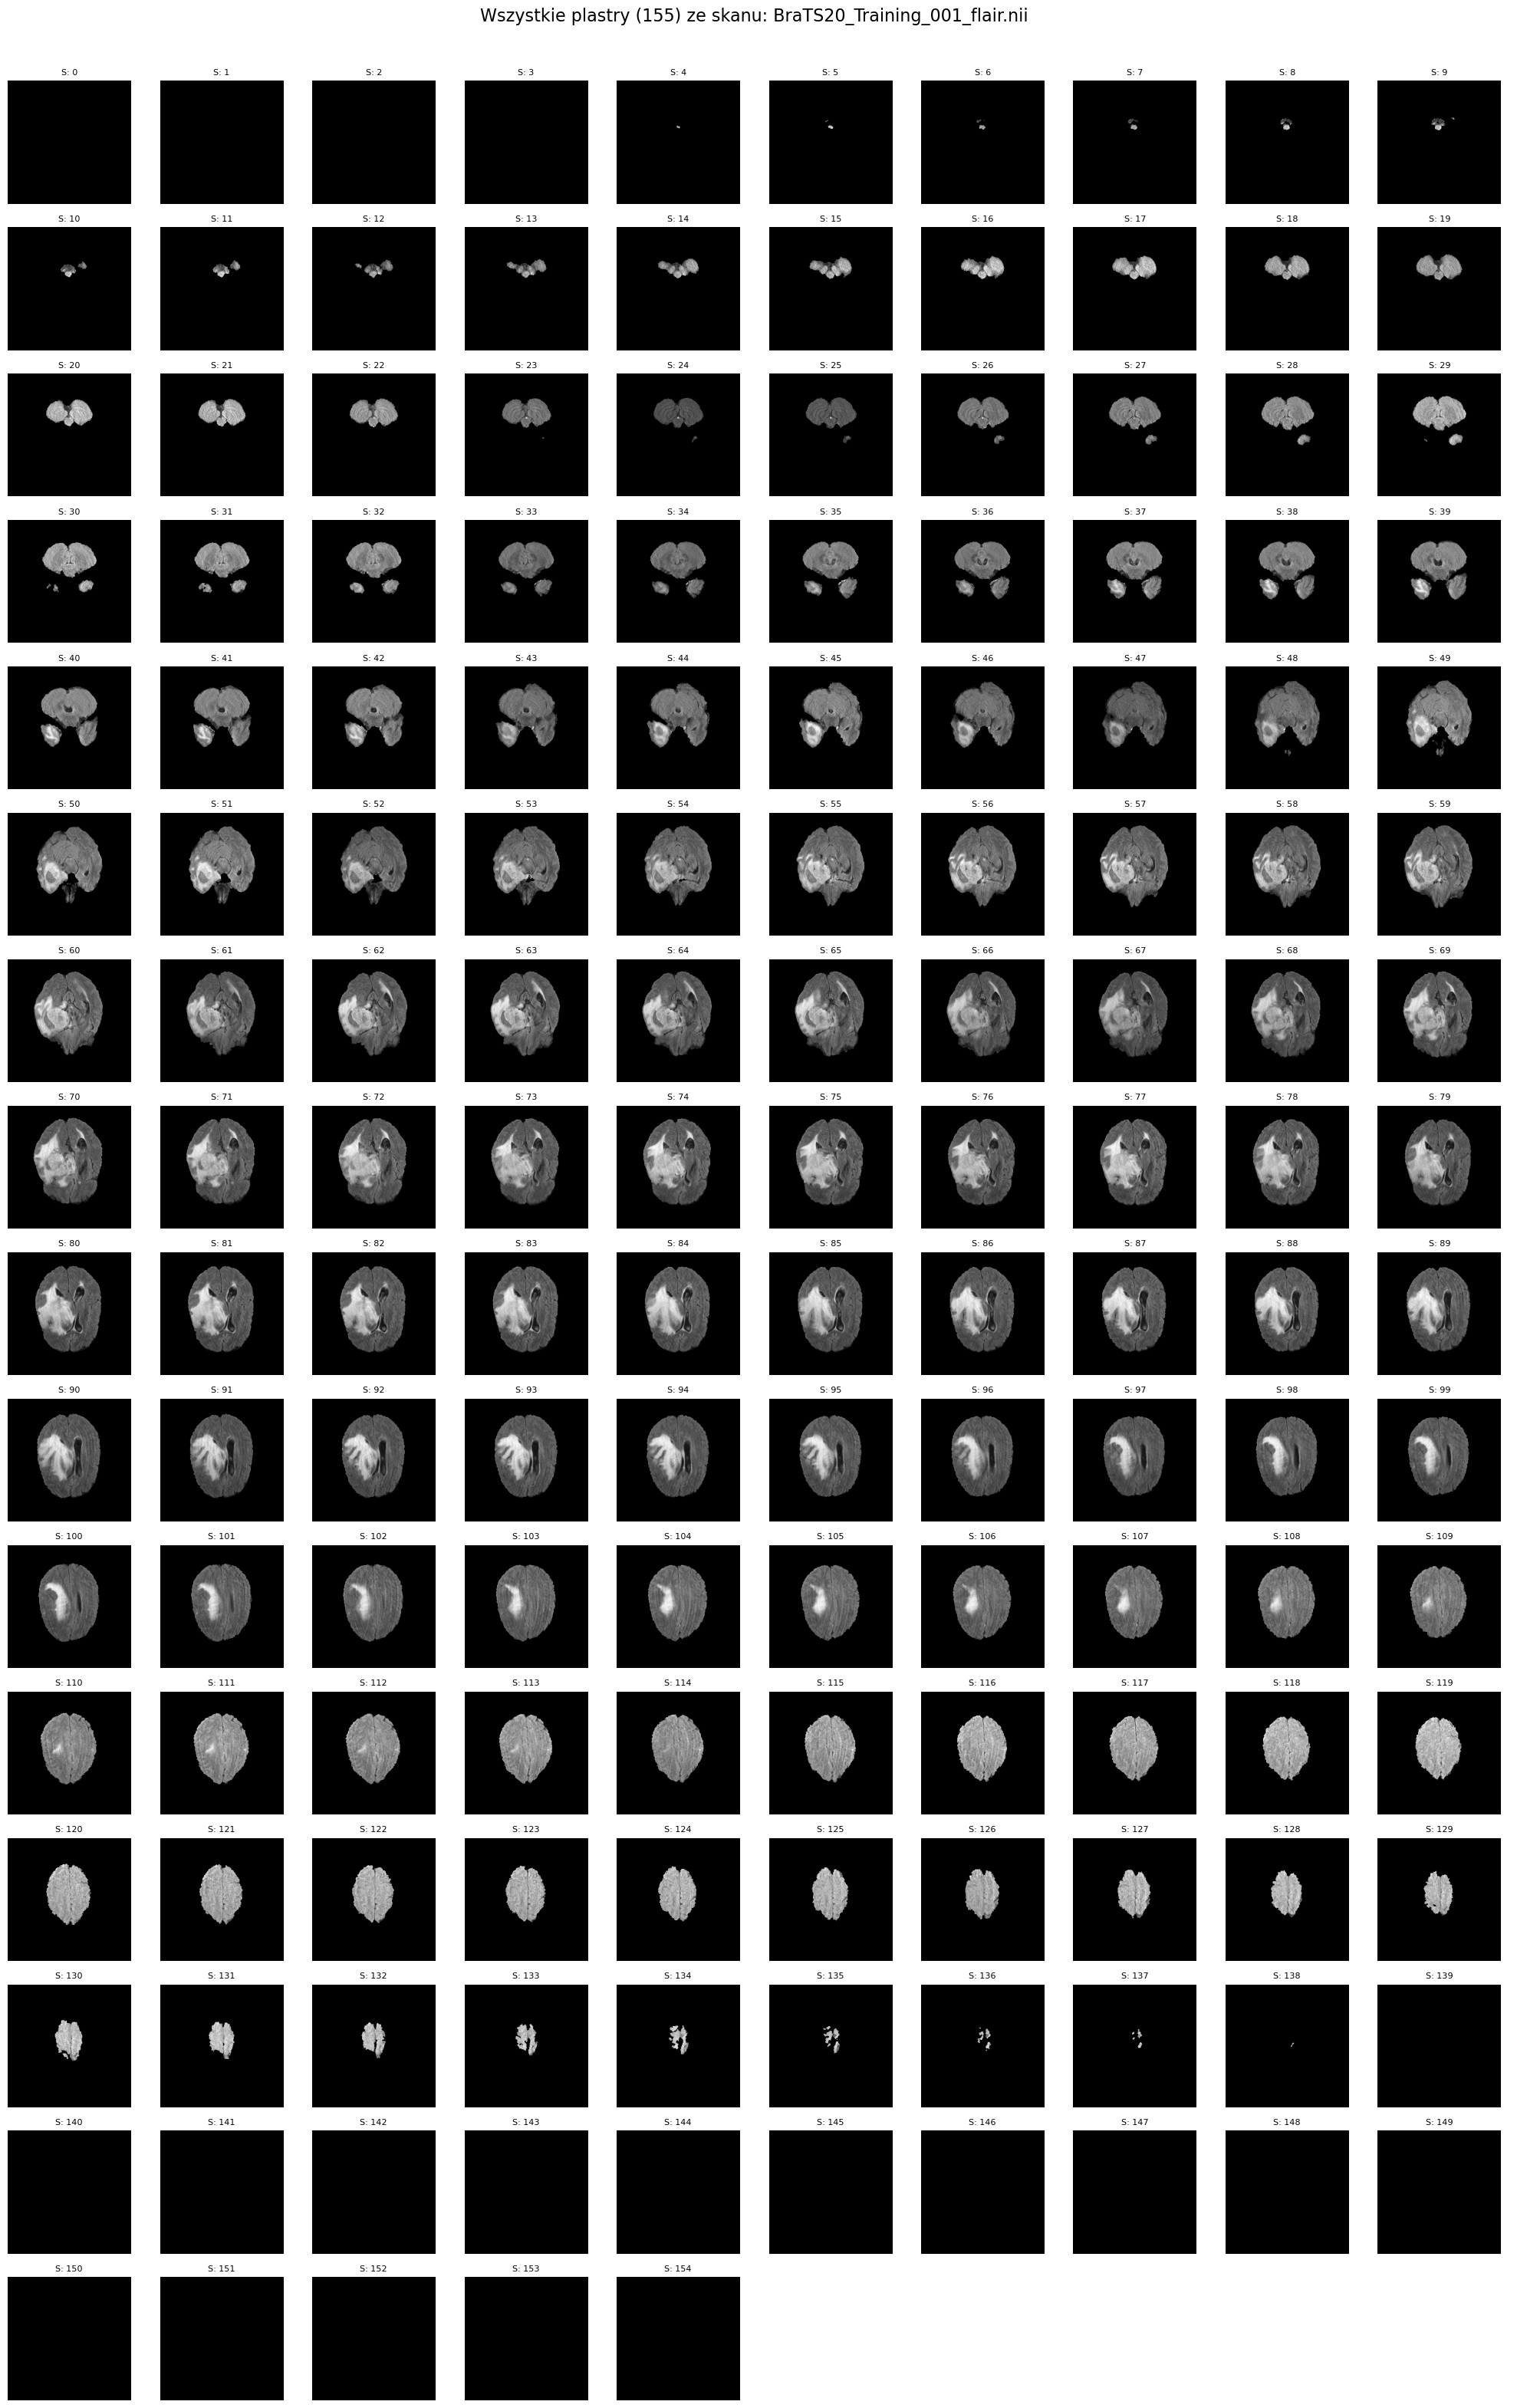

In [6]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import math

# 1. Podaj ścieżkę do jednego pliku .nii z BraTS
sciezka = "/Users/filip/Desktop/INŻYNIERKA/datasets/BraTS2020 Dataset (Training + Validation)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii"

# 2. Wczytanie danych
vol = nib.load(sciezka).get_fdata()
n_slices = vol.shape[2] # Zazwyczaj 155

# 3. Ustalenie wymiarów siatki (np. 10 kolumn)
cols = 10
rows = math.ceil(n_slices / cols)

# 4. Tworzenie ogromnego wykresu
fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))
fig.suptitle(f"Wszystkie plastry ({n_slices}) ze skanu: {sciezka.split('/')[-1]}", fontsize=16)

for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    if i < n_slices:
        # Wybieramy plaster, obracamy go dla lepszej widoczności
        plaster = np.rot90(vol[:, :, i])
        ax.imshow(plaster, cmap='gray')
        ax.set_title(f"S: {i}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()